Formation OpenClassrooms DS-IML - **Marc Lefèvre**, <marc.lefevre@noos.fr>

# Projet 4 : **OLIST Customers Clustering**

# **Troisième Partie : Segmentation au delà des variables RFM...**

## **1 - Introduction**

### **a) - Démarche :**

Après avoir précédemment effectué une **segmentation RFM** (un peu originale...), nous allons tenter dans cette troisième partie d'aller plus loin. Afin d'en apprendre plus sur notre clientèle, nous allons en effet à nouveau utiliser le **machine learning non-supervisé** mais avec d'autres, et plus, de variables.<br><br>Nous souhaitons vous montrer comment, avec certains outils, on peut ainsi détecter informations et tendances dans nos données, voir même esquisser le contour de **persona**, c'est à dire de **profils types** représentatifs de groupes d'individus, en l'occurence ici, de clients.<br><br>Le but étant naturellement,et encore, de récolter des éléments susceptibles d'être exploités du point de vue **marketing**.

### **b) - Déroulement :**

Le principe est simple. Nous définissons un cadre de recherche, c'est à dire un groupe de variables, nous lançons un **algorithme de clustering** que nous jugeons adapté à nos données, puis nous analysons les résultats en en gardant les éléments intéressants.

Au sujet des outils à disposition, en plus de **K-Means** que nous avons déjà vu, nous avons aussi utilisé :<br><br>- **K-Modes** : Il s'agit d'un algorithme calqué sur **K-Means**, sauf qu'il fonctionne avec des variables catégorielles. L'idée est que plutôt que de travailler avec des **distances** et des **moyennes**, **K-Modes** mesure des similarités et différences entre individus selon qu'ils partagent ou pas les mêmes catégories.<br><br>- **K-Prototypes** : Il s'agit d'un condensé de **K-Means** et **K-Modes** capable de tourner sur des données marriant variables numériques et catégorielles.<br><br>- **DBSCAN** : Cet algorithme est tout à fait différent des précédents et son acronyme dérive de la définition suivante : **D**ensity **B**ased **S**patial **C**lustering of **A**pplications with **N**oise. **DBSCAN** procède à des segmentations en se basant sur des densités de points plutôt que sur des distances, ce qui lui permet des détecters des clusters concaves.<br><br><img src = "Data/km_dbscan.png"><br><br>Son utilisation est également très différentes. Avec lui on ne définit pas à l'avance un nombre de clusters à obtenir, mais on fixe (entre autre...) deux hyper-paramètres importants, l'un définissant une distance et l'autre un groupe minimum de point pouvant former un cluster. De là, l'algorithme itère parmis tout les individus en regroupant entre eux ceux se trouvant "à portée" de la distance définie.

Nous avons donc utilisé tous ces algorithmes au cours de la réalisation de cette étude. Néanmoins, il est de bonne pratique de privilégier autant que possible **K-Means** et **K-modes** qui sont beaucoup moins gourmands en ressources totales. De plus, les résultats que nous présentons ici ont été obtenus exclusivement avec eux.

### **c) - Précision :**

La segmentation est un exercice de persévérance. C'est à dire que si les algorithmes donneront toujours des résultats, la valeurs de ceux-ci, au regard de l'interprétation et des actions qu'on peut en tirer, peut s'avérer très variable.<br><br>Dès lors, ici, nous privilégions l'explication de la démarche par des exemples simples plutôt que les résultats en eux-même. Nous reviendrons là-dessus dans notre conclusion.

## **2 - Étapes préliminaires**

### **a) - Importation des bibliothèques python utiles**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import pickle
import warnings

from time import time
from tqdm.notebook import trange, tqdm

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score

from kmodes.kmodes import KModes
from kmodes.kprototypes import KPrototypes

pd.options.display.max_columns = 60

warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

sns.set()

### **b) - Définitions de Fonctions utiles**

**Note :** Même si on ne les voit pas toutes utilisées dans ce compte-rendu, elles l'ont été dans sa préparation.

Boucles **K-Means**, **K-Modes** et **K-Prototypes**.

In [47]:
def kmeans(df, liste_k):
    """
    Fonction renvoyant les inerties et les silhouettes-score de segmentations K-Means en fonction d'une
    liste de valeurs K. Renvoie les liste d'inerties, des scores, et le temps mis sur la boucle.
    """
    
    cost = []
    score = []
    start = time()
    
    for n in tqdm(liste_k):
        km = KMeans(n_clusters=n, verbose=0, random_state = 47)
        km.fit(df)
        pred = km.predict(df)
        silhouette_avg = silhouette_score(df, pred)
        cost.append(km.inertia_)
        score.append(silhouette_avg)
    
    temps = time() - start
    
    print(f"Temps de segmentation : {temps}")
    
    return cost, score, temps



def kmodes(df, liste_k, init = "cao"):
    """
    Fonction renvoyant les coûts et les silhouette-score de segmentations K-Modes en fonction d'une
    liste de valeurs K. Renvoie les liste des coûts, des scores, et le temps mis sur la boucle.
    """
    
    cost = []
    score = []
    start = time()
    
    for n in tqdm(liste_k):
        km = KModes(n_clusters=n, init = "Cao", verbose=0, random_state = 47)
        km.fit(df)
        pred = km.predict(df)
        silhouette_avg = silhouette_score(df, pred)
        cost.append(km.cost_)
        score.append(silhouette_avg)
    
    temps = time() - start
    
    print(f"Temps de segmentation : {temps}")
    
    return cost, score, temps



def kmodes_u(df, k):
    """
    Renvoie une segmentation K-Modes unique d'un dataframe df en fonction d'un nombre de cluster k donné 
    """
    
    start = time()

    km = KModes(n_clusters = k, init = "Cao", verbose=0, random_state = 47)
    pred = km.fit_predict(df)

    temps = time() - start

    print(f"Temps de segmentation : {temps}")
    
    return pred, km.cluster_centroids_


def kmeans_u(df, k):
    """
    Renvoie une segmentation K-Means unique d'un dataframe df en fonction d'un nombre de cluster k donné 
    """
    
    start = time()

    km = KMeans(n_clusters = k, random_state = 47)
    pred = km.fit_predict(df)

    temps = time() - start

    print(f"Temps de segmentation : {temps}")
    
    return pred, km.cluster_centers_


def kproto(df, liste_k, liste_cate, init = "cao"):
    """
    Boucle sur k de segmentations K-Prototypes.
    Retourne les listes de costs et de silhouette-scores
    liste_cate doit être une liste d'index des variables catégorielles.
    """
    
    cost = []
    score = []
    
    start = time()
    
    for n in tqdm(liste_k):
        kp = KPrototypes(n_clusters = n, init = "Cao", verbose=0, random_state = 47)
        pred = kp.fit_predict(df, categorical = liste_cate)
        silhouette_avg = silhouette_score(df, pred)
        cost.append(kp.cost_)
        score.append(silhouette_avg)
        
    temps = time() - start
    
    print(f"Temps de segmentation : {temps}")
        
    return cost, score, temps



def k_plot(cost, score, n=2) :
    """
    Trace les courbes de coûts/inerties et silhouette-score en fonction de K
    """
    
    y = np.array([i for i in range(n, n + len(cost))])
    
    fig = plt.figure(figsize = (12, 5))
    
    plt.subplot(1,2,1)
    plt.plot(y, cost)
    
    plt.title("Cost en fonction de K")
    
    plt.subplot(1,2,2)
    plt.plot(y, score)
    
    plt.title("Silhouette Score en fonction de K")
    
    plt.show()

Boucles **DBSCAN**

In [4]:
def grid_dbs(df, l_metrics, l_ms, l_eps, str_name, nb_limit = 5) :
    """
    A partir d'un dataset, de listes de métriques, de valeurs "min_samples" et "eps", renvoie dans
    un dataframe les caractéristiques de segmentations DBSCAN.
    Sauvegarde les résultats en utilisant le paramètre str "str_name"
    Ne renvoie que les résultats ayant un nb de cluster inférieur/égale à "nb_limit"   
    """
    
    dic_db = {"nb_cl" : [],
              "metric" : [],
              "eps" : [],
              "min_s" : [], 
              "pop_cl" : [],
              "silhouette" : [],
              "temps" : []
             }

    for metr in tqdm(l_metrics) :

        for ms in tqdm(l_ms):

            for n in tqdm(l_eps) :
                
                start = time()
                db = DBSCAN(eps=n, min_samples=ms, metric = metr, algorithm = 'auto').fit(df)
                temps = time() - start
                res = pd.DataFrame()
                res["db_1"] = db.labels_
                nb_cl = res["db_1"].unique().shape[0]
                #silhouette = silhouette_score(df, res["db_1"])

                if nb_cl == 1 :

                    break
                
                #silhouette = silhouette_score(df, res["db_1"])

                if nb_cl <= nb_limit :
                    
                    silhouette = silhouette_score(df, res["db_1"])

                    dic_db["nb_cl"].append(nb_cl)
                    dic_db["metric"].append(metr)
                    dic_db["eps"].append(n)
                    dic_db["min_s"].append(ms)
                    dic_db["pop_cl"].append(res["db_1"].value_counts().values)
                    dic_db["silhouette"].append(silhouette)
                    dic_db["temps"].append(temps)

    df_res = pd.DataFrame(dic_db)
    pickle_out = open("Data/df_res_" + str_name + ".pickle", "wb")
    pickle.dump(df_res, pickle_out)
    pickle_out.close()

    return df_res

Fonctions d'**affichage** de graphiques.

In [46]:
def graph_num_data(df, col, hue, n_bins, height, aspect, log = False):
    """
    Distribution Plot de variables quantitatives/numériques en fonctions de clusters.
    - "df" est le dataframe de données concernées.
    - "col" la variable numérique à représenter.
    - "hue" la variable contenant les labels des clusters.
    - "n_bins" le nombre de segments de la variable numérique.
    - Viennent ensuite des paramètres de hauteur, d'aspect.
    - Le dernier paramètre indique si l'échelle des ordonnées doit être logarithmique
    """
    
    sns.displot(df, 
                x = col, 
                hue = hue, 
                bins = n_bins, 
                multiple="dodge", 
                height = height, 
                aspect = aspect, 
                palette = "tab10")
    
    if log :
        plt.yscale('log')
        
    plt.show()
    
    
    
    
    
def graph_cat_data(df, col, height, aspect, rot = 0) :
    """
    Trace le "Categorical Plot" normalisé d'une variable catégorielle en fonction de clusters.
    - "df" est le dataframe de données concernées.
    - "col" la variable à représenter.
    - Viennent ensuite des paramètres de hauteur, de largeur et d'inclinaison des légendes d'abcisse.
    """
    
    dat = df.copy()
    
    for n in dat[col].value_counts().values:
        
        if n == 0 :
            
            dat[col] = dat[col].cat.remove_unused_categories() 
    
    data = dat.groupby(col)["cluster"].value_counts().rename("pourcentage").reset_index()

    liste_cluster = dat["cluster"].value_counts().index.to_list()
    pop_cluster = dat["cluster"].value_counts().values

    def map_pop(x):

        return pop_cluster[liste_cluster.index(x)]

    data["cluster_pop"] = data["cluster"].apply(map_pop)

    data["pourcentage"] = (data["pourcentage"] / data["cluster_pop"]) * 100
    
    data = data.drop("cluster_pop", axis = 1)
    
    graph = sns.catplot(x = col, 
                    y = 'pourcentage', 
                    hue = "cluster", 
                    kind = 'bar', 
                    data = data, 
                    height = height, 
                    aspect = aspect)

    graph.set_xticklabels(rotation=rot)

    plt.title(f"Populations de {col}")

    plt.show()    

    
    
def graph_oh_data(dataf, cols, titre, length, width, rot = 0) :
    """
    Trace le "Bar Plot" d'une variable catégorielle disséminée en "dummy variables" suite, pat exemple, à un
    encodage "One Hot".
    - "df" est le dataframe de données concernées.
    - "cols" la liste de colonnes représentant les "dummy variables" concernées.
    - "titre" est le titre du graph sous forme str.
    - Viennent ensuite des paramètres de hauteur, de largeur et d'inclinaison des légendes d'abcisse.
    """
    
    df = dataf[cols]
    df["cluster"] = dataf["cluster"]
    df = df.groupby("cluster").sum().reset_index()
    data = df.drop("cluster", axis = 1).T
    data = (data/data.sum())*100
    
    data.plot.bar(rot=rot, figsize = (length, width ))
    plt.title(titre)
    plt.show  

Fonction autour des réductions **T-SNE** et de leurs représentations.

In [6]:
def calc_tsne(df, perp, name) :
    """
    
    """
    
    start = time()

    tsne = TSNE(n_components=2, init='pca', perplexity = perp, random_state = 47)
    red_tsne = tsne.fit_transform(df)
    df_tsne = pd.DataFrame(red_tsne, columns = ["tsne_1", "tsne_2"])
    
    temps = time()-start
    
    name = "Data/tsne_" + name + ".pickle"
    
    pickle_out = open(name, "wb")
    pickle.dump(df_tsne, pickle_out)
    pickle_out.close()
    
    print(f"Nous avons mis {temps} secondes à calculer la réduction.")

    return df_tsne


def graph_tsne(df, pred, nb_cl):
    """
    
    """
    
    #sns.color_palette("tab10")
    plt.figure(figsize = (13,13))
    sns.scatterplot(x = "tsne_1", 
                    y = "tsne_2",
                    hue = pred,
                    palette = sns.color_palette("hls", nb_cl),
                    data = df,
                    legend = "full",
                    alpha = 0.5
                   )
    plt.show()
    
    
def graph_just_tsne(df):
    """
    
    """
    
    plt.figure(figsize = (7,7))
    sns.scatterplot(x = "tsne_1", 
                    y = "tsne_2",
                    data = df,
                    #legend = "full",
                    alpha = 0.5
                   )
    plt.show()

### **c) - Mise en forme des données**

Nous allons à nouveau transformer notre dataset, dont les individus sont encore des **produits commandés**, en **bases clients**. En amont de cette opération nous allons également procéder à un encodage **one hot** des variables catégorielles.

### **Dataset client avec encodage One Hot**

In [ ]:
# Récupération des données
df = pickle.load(open("Data/full_data_cs.pickle", "rb"))

# Encodage One Hot
df_enc = pd.get_dummies(df, columns = df.columns[6:], 
                        prefix = ["MC", "", "rev", "", "", "month", "quarter", "day", "day_q", ""], 
                        prefix_sep = ["_", "", "_", "", "", "_", "_", "_", "_", ""])

# Création de "prod_count"
df_enc["prod_count"] = 1

# Dictionnaire du premier regroupement
keys = df_enc.columns[1:].tolist()
values = ["first"] * (len(df_enc.columns) -2) + ["sum"]

dico_com = {k : v for k, v in zip(keys, values)}

# Regroupement
df_com = df_enc.groupby("order_id").agg(dico_com).reset_index()
df_com = df_com.drop("order_id", axis = 1)

# Dictionnaire du second regroupement
keys = df_com.columns[1:].tolist()
values = (["first"] * 3) + ["sum"] + ["first"] * (len(df_com.columns) - 6) + ["sum"]

dico_cust = {k : v for k, v in zip(keys, values)}

# Second regroupement
df_cust = df_com.groupby("customer_unique_id").agg(dico_cust).reset_index()
df_cust = df_cust.drop("customer_unique_id", axis = 1)

# Sauvegarde
pickle_out = open("Data/df_clust_ohb.pickle", "wb")
pickle.dump(df_cust, pickle_out)
pickle_out.close()

Liste de "dummy variables" représentant nos variables initiales, avant encodage **One Hot**.

In [4]:
df = pickle.load(open("Data/df_clust_ohb.pickle", "rb"))

# Définition des "portions" du dataset représentant chacune des variables avant encodage
divers = df.columns[:4].tolist() + [df.columns[-1]]
M_class = df.columns[4:7].tolist()
class_RF = df.columns[7:12].tolist()
review = df.columns[12:17].tolist()
etats = df.columns[17:23].tolist()
payment = df.columns[23:27].tolist()
month = df.columns[27:39].tolist()
quarter = df.columns[39:43].tolist()
day = df.columns[43:50].tolist()
day_q = df.columns[50:54].tolist()
prod_cat = df.columns[54:-1].tolist()
prod_count = [df.columns[-1]]

## **2 - Exemple de segmentation globale**

### ***K-Modes sur : M_class + etats + payment + month + prod_cat***

Nous allons faire une segmentation globale, c'est à dire sur tous les clients. Durant celle-ci, nous allons tenir compte d'une façon "large" des montants dépensés avec **M_class**, de son état de résidence, de sa méthode de paiement, de sa période d'achat de l'année, et de la catégorie de produit acheté.<br>Comme nous n'avons ici que des variables catégorielles, nous allons utiliser **K-Modes**.

In [14]:
# Chargement données
df = pickle.load(open("Data/df_clust_ohb.pickle", "rb"))
# Choix des variables
df = df[M_class + etats + payment + month + prod_cat]

Boucle de segmentation

In [15]:
c, s, t = kmodes(df, list(range(2, 15)))
print(f"La boucle a mis {t} sec.")


La boucle a mis 2656.171761035919 sec.


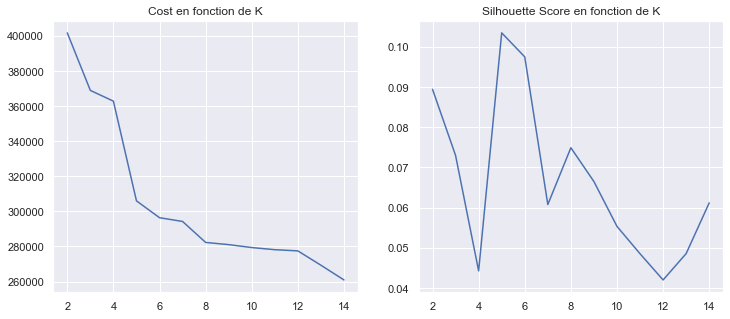

In [16]:
k_plot(c, s)

Le choix de **k** par la **méthode du coude** indique que **k = 6** pourrait être un choix valable même si les **silhouette-scores** obtenus sont loins d'être brillants. Comme notre but est avant tout d'expliquer une démarche, nous allons regarder plus en détails la segmentation obtenu pour ce **k = 6**. 

Détermination des clusters pour **k = 6**.

In [17]:
df["cluster"], centres = kmodes_u(df, 6)

Temps de segmentation : 88.29212379455566


Population des clusters :

In [18]:
df["cluster"].value_counts()

0    27079
4    25475
2    19385
1     8595
5     7905
3     5648
Name: cluster, dtype: int64

Les populations des clusters sont inégales mais significatives.

Observons les **centroïdes** des clusters.

In [20]:
df_centroids = pd.DataFrame(centres, columns = df.columns[:-1])
df_centroids

,MC_1,MC_2,MC_3,Autre,MG,PR,RJ,RS,SP,boleto,credit_card,debit_card,voucher,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,auto,baby,computer_electronics_multimedia,cool_stuff,food_drink,furniture_decor,garden_construction_tools,health_beauty_hygyene,house,housewares_home_appliances,luggage_bags_accessories_fashion,office_furniture_stationery,perfumery,pet_shop,sports_leisure_art,telephony,toys,watches_gifts
0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Les centroids nous donnent des indications sur le "coeur" de chaque cluster. Mais passons à l'examination des clusters catégorie par catégorie.

### **Observation des variables par cluster**

**M_class des clients**

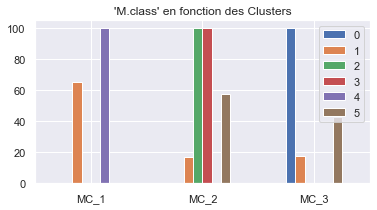

In [21]:
graph_oh_data(df, df.columns[:3], "'M.class' en fonction des Clusters", 6, 3)

**Etats de résidence des clients**

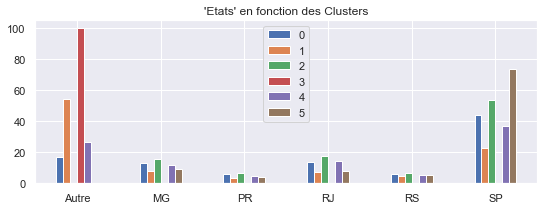

In [24]:
graph_oh_data(df, df.columns[3:9], "'Etats' en fonction des Clusters", 9, 3)

**Types de paiement**

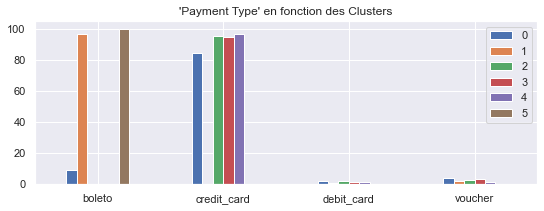

In [26]:
graph_oh_data(df, df.columns[9:13], "'Payment Type' en fonction des Clusters", 9, 3)

**Mois d'achat dans l'année**

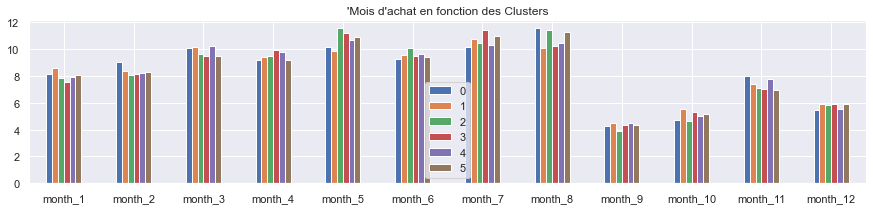

In [28]:
graph_oh_data(df, df.columns[13:25], "'Mois d'achat en fonction des Clusters", 15, 3)

Cette variable ne montre pas de variation significative par cluster (on aurait pu nous en passer), elle montre juste un mouvement global d'augmentation des commandes de septembre à aout de l'année suivante (avec une bosse notable en novembre).

**Catégorie de produits achetés**

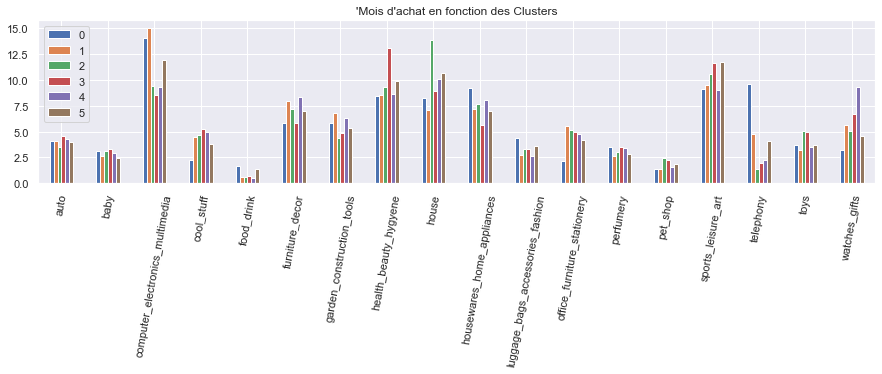

In [32]:
graph_oh_data(df, df.columns[25:], "'Mois d'achat en fonction des Clusters", 15, 3, 80)

Sans pousser très loin dans le détail, on peut noter des accointances de certains clusters pour certaines catégories de produits.

In [33]:
df["cluster"].value_counts()

0    27079
4    25475
2    19385
1     8595
5     7905
3     5648
Name: cluster, dtype: int64

### **Que tirer de cette segmentation ?**

Analyse rapide des différents clusters caractérisés par cette segmentation.

**Cluster 0 (bleu)** de **27 079** clients :<br>- Uniquement des clients de la **M_class** la **moins dépensière**.<br>- Majoritairement de **Sao Paulo**.<br>- Payent surtout par **Carte de crédit**.<br>- Attrait pour la catégorie **informatique** et plus fort attrait pour la **téléphonie**.

**Cluster 1 (orange)** de **8 595** clients :<br>- A **60%** de la **M_class 1** la **plus dépensière**.<br>- Payent à **95%** avec **boleto**<br>- Plus fort attrait pour la catégorie **informatique**.

**Cluster 2 (vert)** de **19 385** clients :<br>- **M_class 2** **intermédiaire**.<br>- Payent par **carte de crédit**.<br>- Plus fort attrait pour les produits de la **maison**.

**Cluster 3 (rouge)** de **5 648** clients :<br>- **M_class 2** **intermédiaire**.<br>- Située hors des 5 plus importants états du pays (en terme de commandes sur le site...)<br>- Payent par **carte de crédit**.<br>- Plus fort attrait pour les produits **santé, beauté, hygiène**.

**Cluster 4 (violet)** de **25 475** clients :<br>- **100%** dans la **M_class 1**.<br>- Payent par **carte de crédit**.<br>- Plus fort attrait pour les catégorie **montres, cadeaux**.

**Cluster 5 (marron)** de **7 905** clients :<br>- Egalement réparti entre les **M_class 2** et **3**.<br>- Très majoritairement de **Sao Paulo**<br>- Paye uniquement par **boleto**.<br>- Intérêts marqués pour les catégories **informatique** et **sport, art, loisir**.

Ce type d'information peut parfaitement être exploité afin de comprendre de quoi est constituée sa clientèle et d'entreprendre toute sorte d'actions.

## **3 - Exemple de segmentation ciblée**

Après une segmentation à l'échelle de notre base client entière, nous pouvons également en faire une sur un sous-groupe de clients qui pourrait posséder à nos yeux un intérêt particulier. Certains groupes pourraient-ils être caractériser chez les acheteurs de téléphonie ou ceux qui utilise des vouchers ?

### ***K-Modes sur : M_class + etats + month + quarter + day + prod_cat*** pour utilisateurs de **voucher**

In [103]:
# Chargement données
df = pickle.load(open("Data/df_clust_ohb.pickle", "rb"))
# Choix des variables
df_v = df[M_class + etats + month + prod_cat][df["voucher"] == 1]

Boucle de segmentation

In [104]:
c, s, t = kmodes(df_v, list(range(2, 15)))


Temps de segmentation : 27.571038484573364


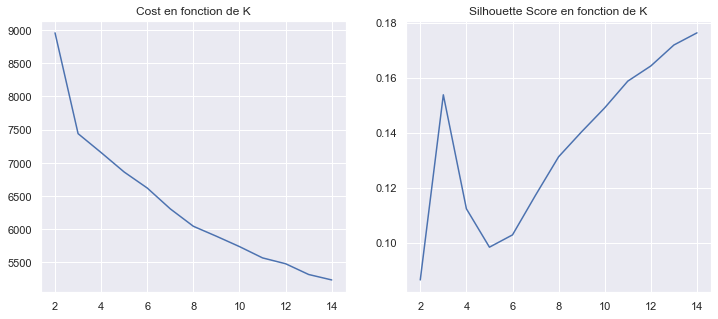

In [105]:
k_plot(c, s)

Un peu arbitrairement, étant donné que notre échantillon est petit (**2480** individus), nous choisissons **K = 3**.

In [107]:
df_v["cluster"], centres = kmodes_u(df_v, 3)

Temps de segmentation : 1.4400017261505127


In [109]:
df_v["cluster"].value_counts()

0    1107
1     769
2     604
Name: cluster, dtype: int64

In [110]:
df_centroids = pd.DataFrame(centres, columns = df_v.columns[:-1])
df_centroids

,MC_1,MC_2,MC_3,Autre,MG,PR,RJ,RS,SP,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,auto,baby,computer_electronics_multimedia,cool_stuff,food_drink,furniture_decor,garden_construction_tools,health_beauty_hygyene,house,housewares_home_appliances,luggage_bags_accessories_fashion,office_furniture_stationery,perfumery,pet_shop,sports_leisure_art,telephony,toys,watches_gifts
0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### **Observation des variables par cluster**

**M_class**

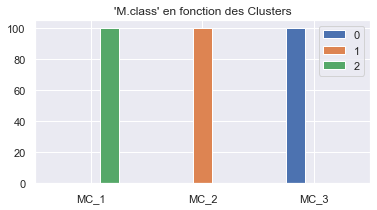

In [112]:
graph_oh_data(df_v, df_v.columns[:3], "'M.class' en fonction des Clusters", 6, 3)

**Etats de résidence des clients**

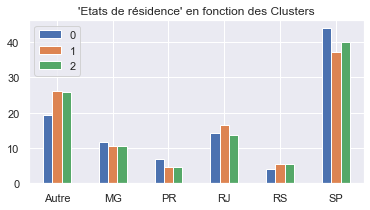

In [114]:
graph_oh_data(df_v, df_v.columns[3:9], "'Etats de résidence' en fonction des Clusters", 6, 3)

**Mois d'achat**

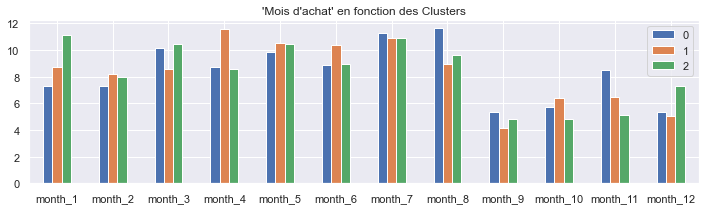

In [117]:
graph_oh_data(df_v, df_v.columns[9:21], "'Mois d'achat' en fonction des Clusters", 12, 3)

**Produits achetés**

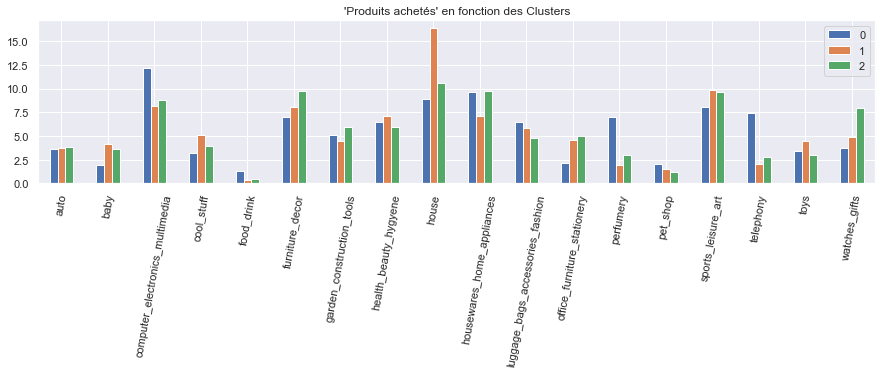

In [120]:
graph_oh_data(df_v, df_v.columns[21:], "'Produits achetés' en fonction des Clusters", 15, 3, 80)

Dans cet exemple, nos clusters se sont calqués sur les catégories d'une des variables. Cela nous facilite l'interprétation des résultats en nous donnant directement les états de résidence, les mois d'achat, et les catégories de produits achetés, **par catégorie de dépense M_class** pour les gens qui payent en **vouchers**.<br>On notera que les dépensiers **intermédiaires** ont une propension pour la catégorie **maison**, que les **petits** dépensiers ont une propension pour la **parfumerie**, la **téléphonie**, et les **produits informatiques**.<br><br>Les résultats ne sont pas très parlants, mais encore, il s'agit juste d'un exemple de segmentation plus ciblée que la première.<br><br>Notre but ici est de vous faire comprendre quels résultats seraient possibles en utilisant la **segmentation** par **machine learning non-supervisé** à partir d'un plus vaste catalogue de données, par exemple avec plus de renseignements de type **état civil**, à partir des données de type **analytics** de la fréquentation de l'appli, etc.<br><br>Si on met de côté l'aspect direction et prise de décision de l'utilisation de ces techniques, l'implementation elle-même est extrêmement simple pour le client. Il suffirait pour lui de nous faire parvenir des données, et nous de les renvoyer enrichies de nouvelles variables classant les clients dans tel ou tel segment de telle ou telle segmentation.

Ce qui nous amène à notre conclusion.

# **Quatrième Partie : Conclusion et proposition de collaboration**

Le premier objectif de notre mission était d'élaborer, à partir des données fournies, une segmentation de la clientèle **Olist** qui permette immédiatement aux équipes de l'entreprise de lancer des actions marketing.<br><br>Même si la **segmentation RF** que nous proposons a cela de surprenant qu'elle court-circuite notre approche initiale combinant **RFM** et **machine-learning**, elle nous parait être la meilleure possible au regard de ce qui ressortait des données (une impérieuse nécessité de booster la fidélisation des clients).<br><br>En marge de ce premier objectif, nous avons tenté de montrer que même s'il ne nous avait pas servi initialement, le **machine learning non-supervisé** pourrait beaucoup apporter si on l'utilisait pour d'autres segmentations à partir d'un matériel de données peut-être plus riche que celui auquel nous avons eu accès.<br><br>Nous invitons donc à la réflexion sur ces sujets, ainsi que sur d'autres possibilités, à d'autres niveaux, offertes par le **machine learning** (moteur de recommandation, etc). Nous nous tenons à la disposition du client pour les évoquer.

## **Annexe : Propositions sur le contrat de maintenance**

**a) Service et rythme des mises à jour.** 

Adopter et utiliser notre **segmentation RF** nécessitera une **mise à jour** périodique des données, que nous accompagnerons de divers éléments comme :<br>- des graphs **stacked area plot** représentant l'évolution de la clientèle<br>- des diagrammes **Sankey**<br>- des listes des clients ayant changé de classe.<br>Autant d'éléments qui **faciliteront** l'observation des **progrès accomplis** et le passage à l'**action**.<br><br>Nous avons déjà les outils logiciels requis, c'est au client et à ses équipes marketing de décider de la périodicité de ces mises à jour. Celles-ci peuvent être quotidiennes, hebdomadaires, mensuelles, (...), nous serons toujours en mesure de répondre à la demande.

**b) Nouvel examen de la base client**

La nature de la clientèle étant appelée à évoluer, il faudra périodiquement s'assurer que la segmentation utilisée reste opérante. Dans le cas présent, aucun modèle de **machine learning** n'est pour l'instant impliqué, il n'y a pas de nécessité de ré-entrainement d'un modèle, on peut donc voir relativement large.<br><br>Prévoir de refaire un point de situation à un horizon de six ou neufs mois nous parait une bonne idée.

**c) La véritable segmentation client reste à faire !**

Comme par la force des choses, une véritable **segmentation client** utilisant le **machine learning non supervisé** reste à faire, il nous faut reprendre rendez-vous pour en discuter^^ !

**Merci de votre attention.**

**Fin du projet 4**